# 06. GRIN medium and analysing refraction

submitted by [substancia](https://github.com/substancia), adapted by [flaport](https://github.com/flaport)

## Imports

In [1]:
import os
import fdtd
import numpy as np
import matplotlib.pyplot as plt

## Grid

In [2]:
grid = fdtd.Grid(shape=(9.3e-6, 15.5e-6, 1), grid_spacing=77.5e-9)
# x boundaries
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")
# y boundaries
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")
simfolder = grid.save_simulation("GRIN")  # initializing environment to save simulation data
print(simfolder)

D:\Project\fdtd\examples\fdtd_output\fdtd_output_2025-3-20-16-54-39 (GRIN)


## Objects
defining a graded refractive index slab, with homogenous slab extensions outwards from both ends

In [3]:
n0, theta, t = 1, 30, 0.5
for i in range(50):
    x = i * 0.08
    epsilon = n0 + x * np.sin(np.radians(theta)) / t
    epsilon = epsilon ** 0.5
    grid[
        5.1e-6:5.6e-6, (5 + i * 0.08) * 1e-6 : (5.08 + i * 0.08) * 1e-6, 0
    ] = fdtd.Object(permittivity=epsilon, name="object" + str(i))

# homogenous slab extensions
grid[5.1e-6:5.6e-6, 0.775e-6:5e-6, 0] = fdtd.Object(
    permittivity=n0 ** 2, name="objectLeft"
)
grid[5.1e-6:5.6e-6, 9e-6 : (15.5 - 0.775) * 1e-6, 0] = fdtd.Object(
    permittivity=epsilon, name="objectRight"
)

## Source
using a pulse (hanning window pulse)

In [4]:
grid[3.1e-6, 1.5e-6:14e-6, 0] = fdtd.LineSource(period=1550e-9 / (3e8), name="source", pulse=True, cycle=3, hanning_dt=4e-15)

## Detectors
using a linear array of LineDetector

In [5]:
for i in range(-4, 8):
    grid[5.8e-6, 84 + 4 * i : 86 + 4 * i, 0] = fdtd.LineDetector(name="detector" + str(i))

## Saving grid geometry

In [6]:
with open(os.path.join("./fdtd_output", grid.folder, "grid.txt"), "w") as f:
    f.write(str(grid))
    wavelength = 3e8/grid.source.frequency
    wavelengthUnits = wavelength/grid.grid_spacing
    GD = np.array([grid.x, grid.y, grid.z])
    gridRange = [np.arange(x/grid.grid_spacing) for x in GD]
    objectRange = np.array([[gridRange[0][x.x], gridRange[1][x.y], gridRange[2][x.z]] for x in grid.objects], dtype=object).T
    f.write("\n\nGrid details (in wavelength scale):")
    f.write("\n\tGrid dimensions: ")
    f.write(str(GD/wavelength))
    f.write("\n\tSource dimensions: ")
    f.write(str(np.array([grid.source.x[-1] - grid.source.x[0] + 1, grid.source.y[-1] - grid.source.y[0] + 1, grid.source.z[-1] - grid.source.z[0] + 1])/wavelengthUnits))
    f.write("\n\tObject dimensions: ")
    f.write(str([(max(map(max, x)) - min(map(min, x)) + 1)/wavelengthUnits for x in objectRange]))

## Simulation

In [12]:
from IPython.display import clear_output  # only necessary in jupyter notebooks

for i in range(100):
    grid.step()  # running simulation 1 timestep a time and animating
    if i % 5 == 0:
        # saving frames during visualization
        grid.visualize(z=0, animate=True, index=i, save=True, folder=simfolder)
        plt.title(f"{i:3.0f}")
        clear_output(wait=True)  # only necessary in jupyter notebooks
grid.save_data()  # saving detector readings

We can generate a video with ffmpeg:

In [8]:
try:
    video_path = grid.generate_video(delete_frames=False)  # rendering video from saved frames
except:
    video_path = ""
    print("ffmpeg not installed?")

ffmpeg not installed?


In [9]:
if video_path:
    from IPython.display import Video
    display(Video(video_path, embed=True))

## Analyse
analysing data stored by above simulation to find intensity profile and time-of-arrival plot

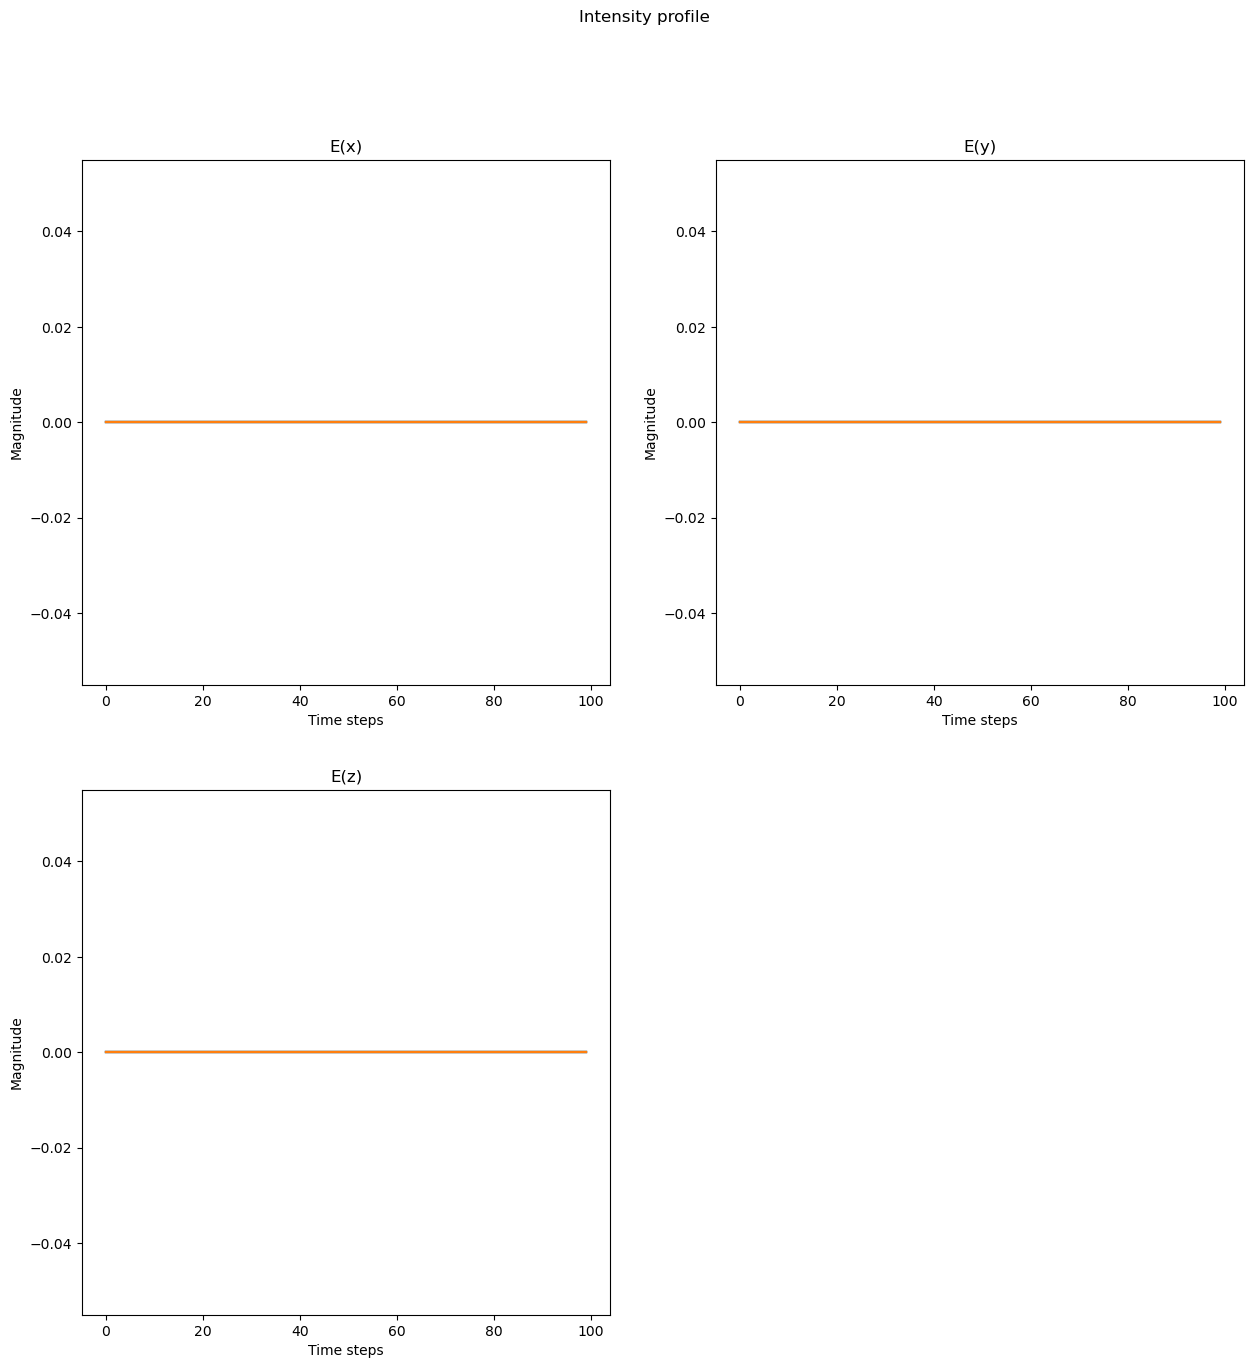

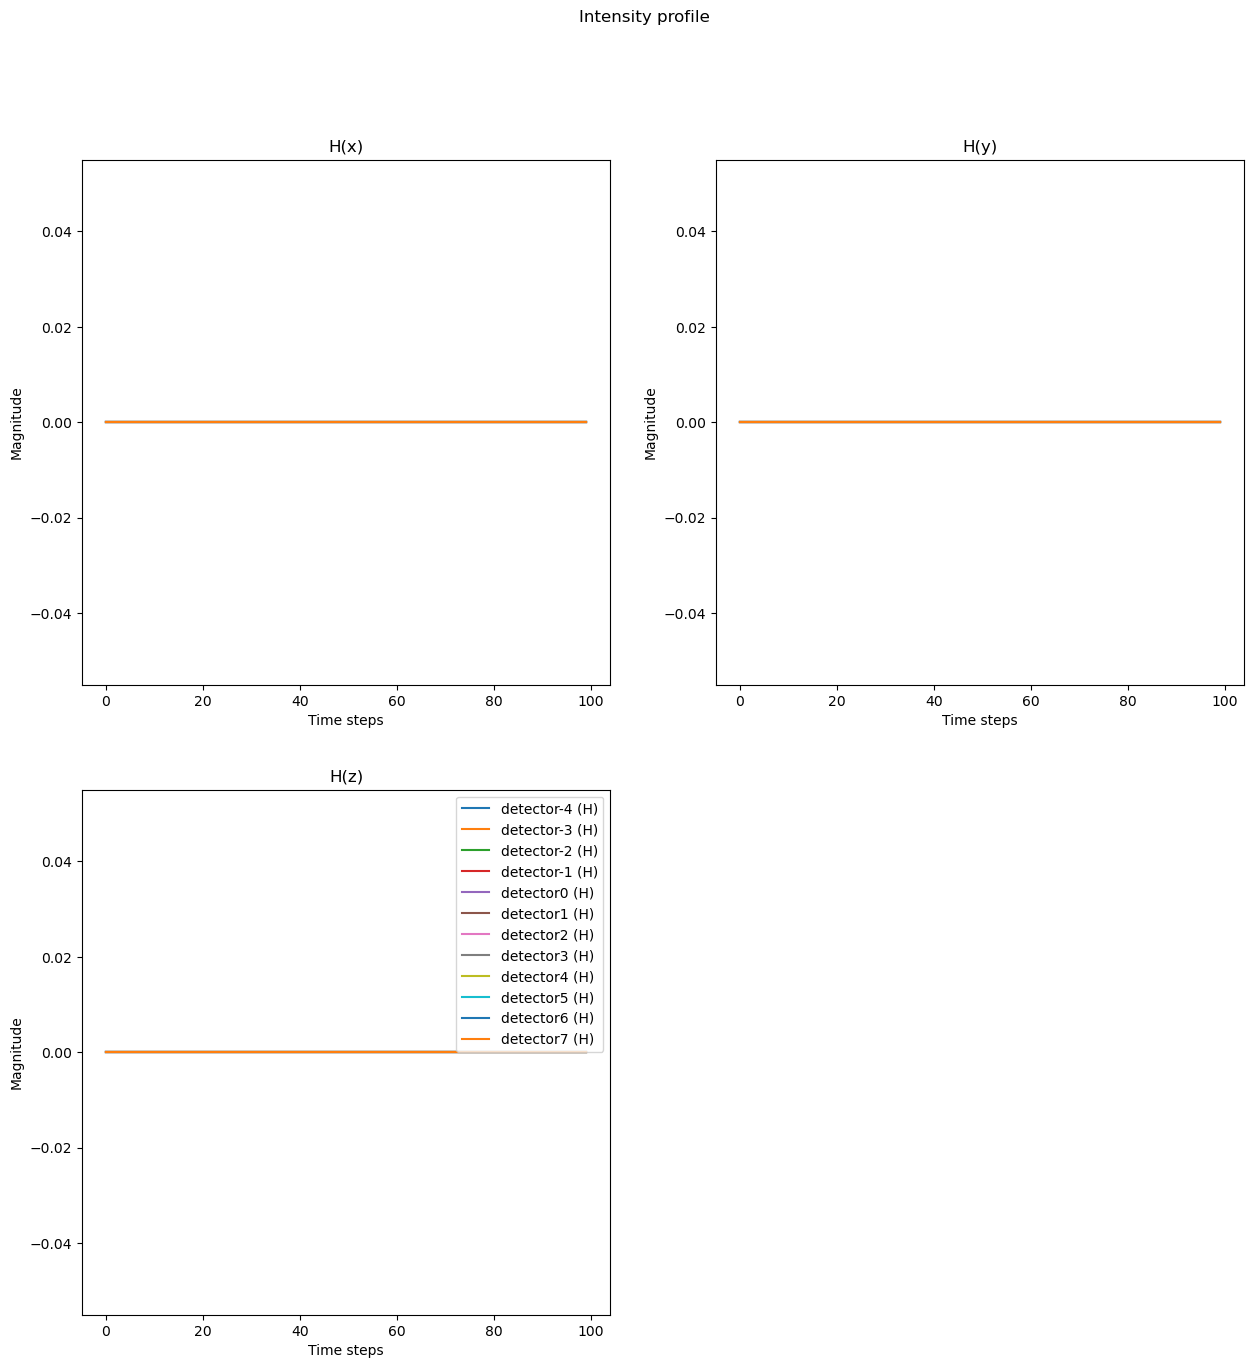

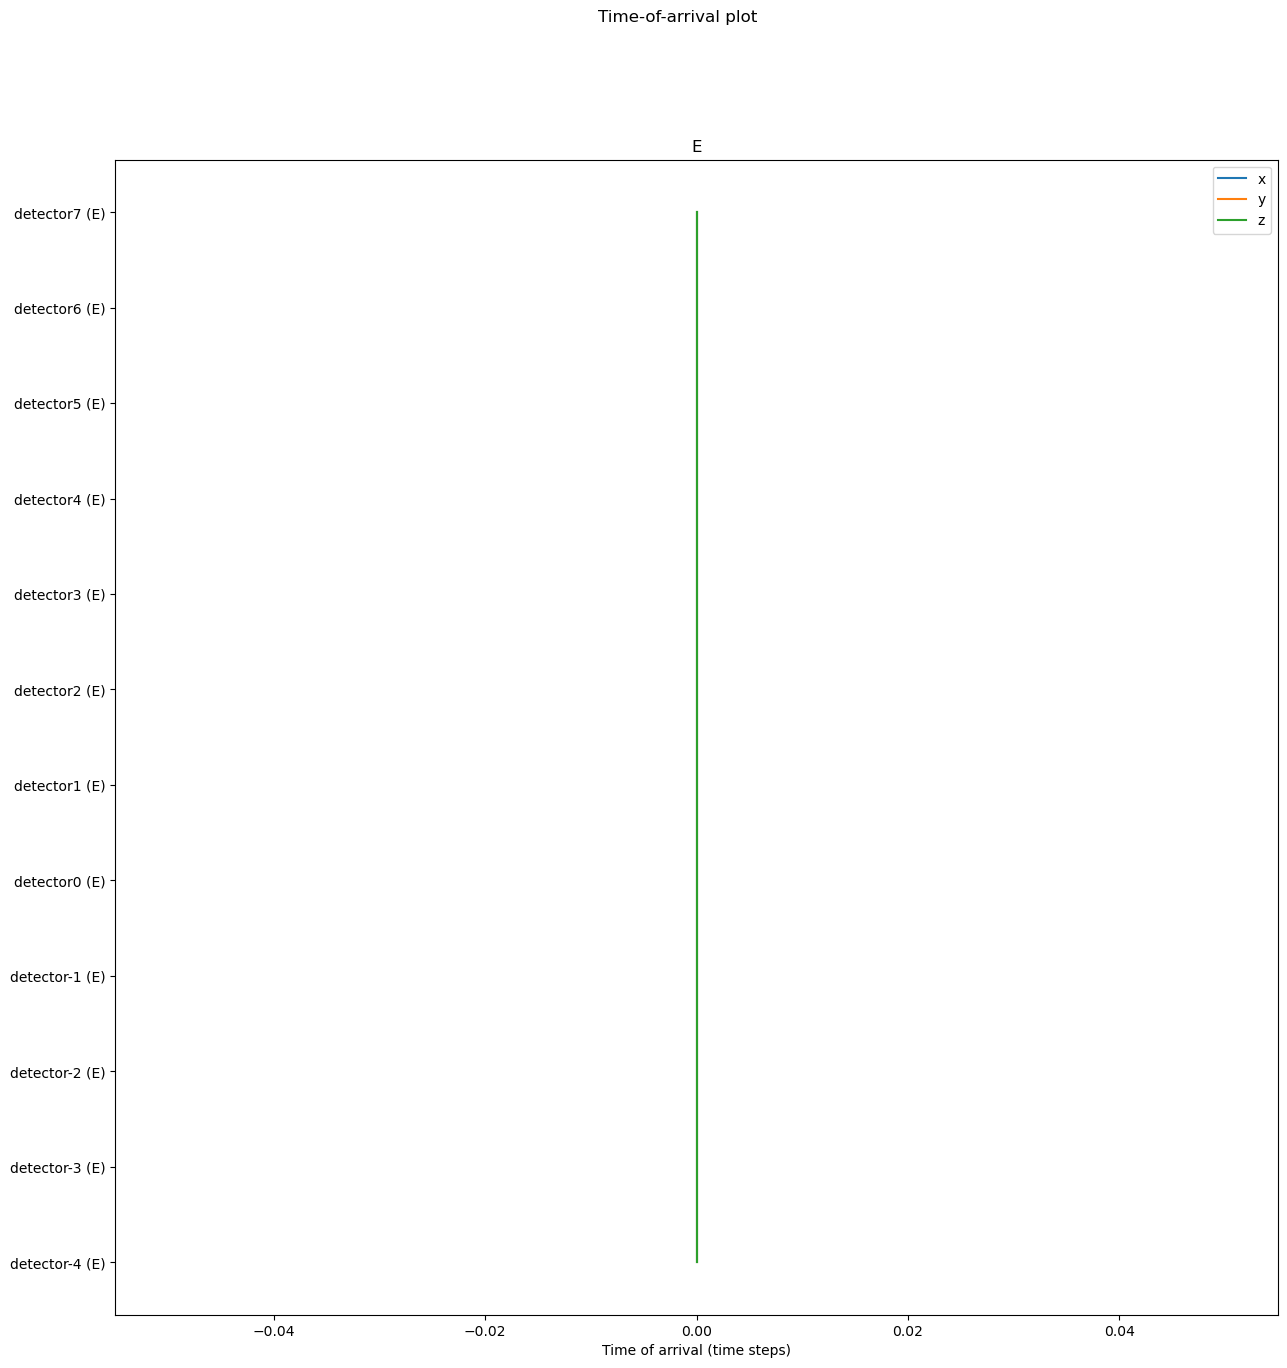

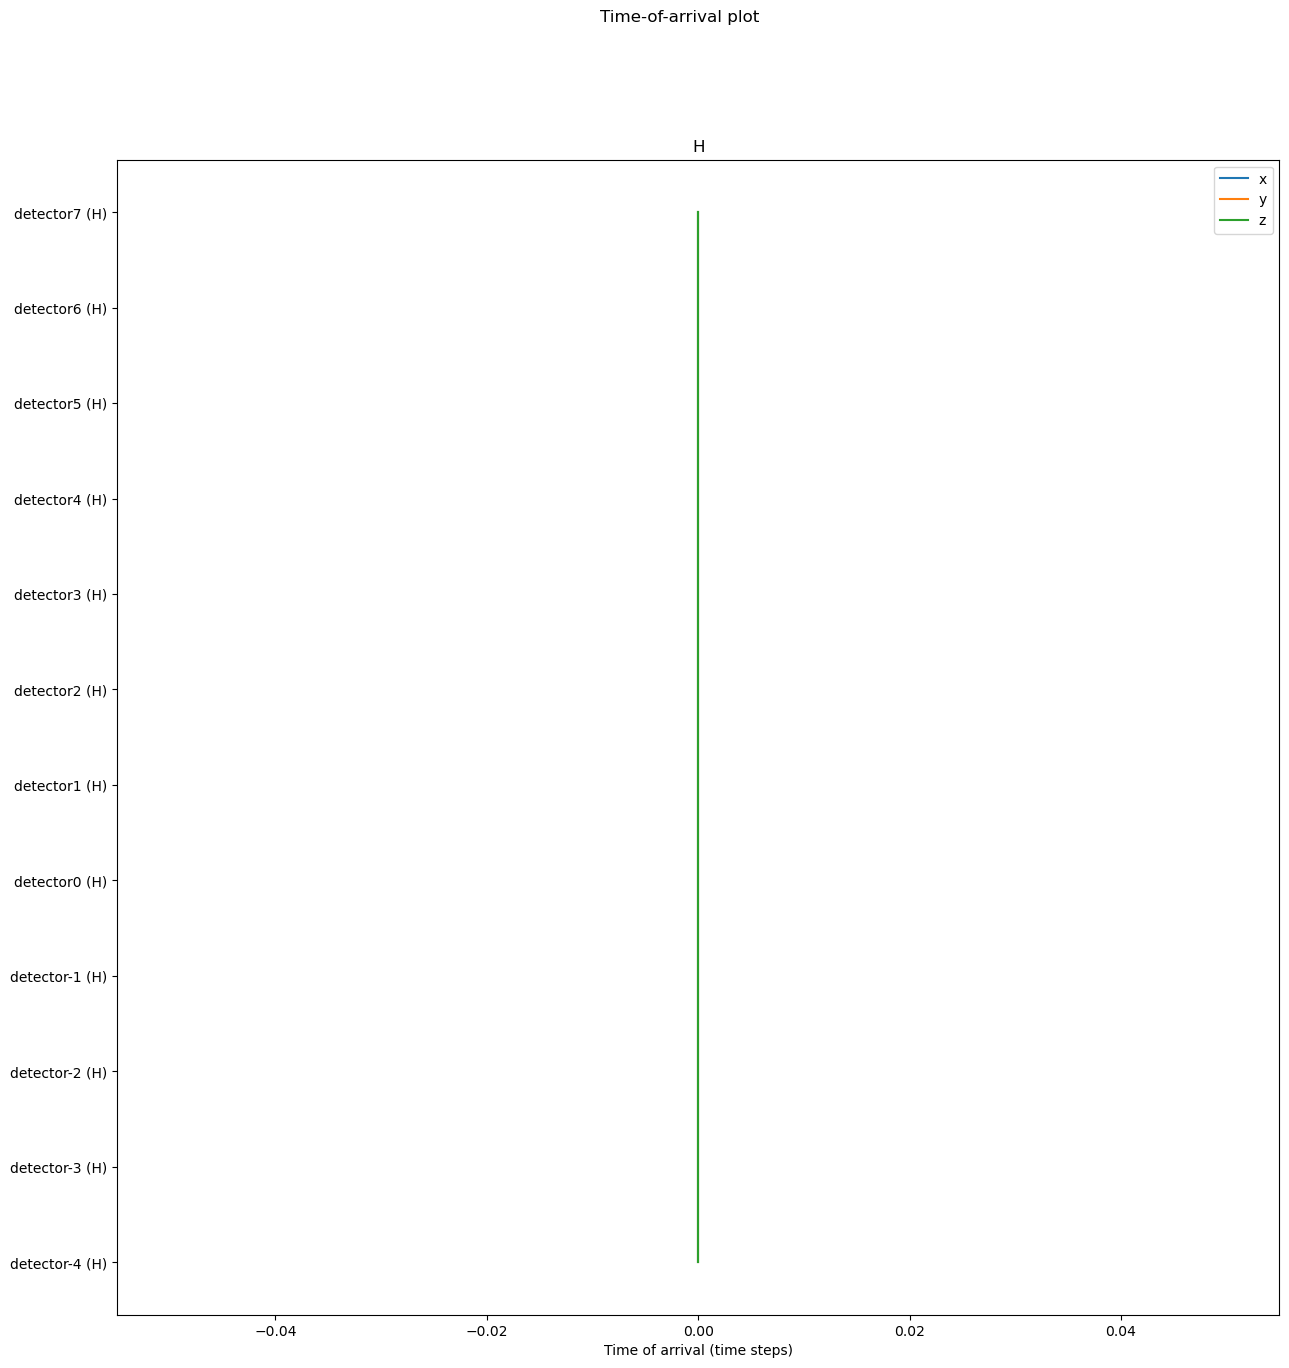

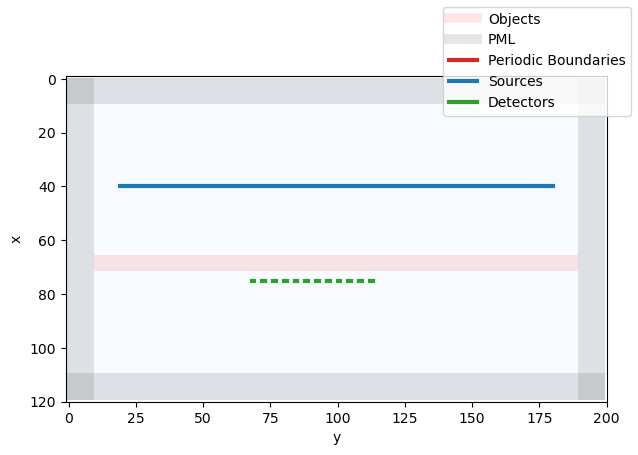

In [11]:
dic = np.load(os.path.join(simfolder, "detector_readings.npz"))
import warnings; warnings.filterwarnings("ignore") # TODO: fix plot_detection to prevent warnings
fdtd.plot_detection(dic)
grid.visualize(z=0) 